In [121]:
import sys,os

sys.path.append('/home/arash/ProjectVR/')

import pandas as pd
import numpy as np
import time
import keras
from math import sqrt
import matplotlib.pyplot as plt
import pickle
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import matplotlib.animation as animation
import deepsurv
import json
import theano.tensor
import keras.backend as K

import scipy
import scipy.stats
import scipy.integrate as integrate

from deepsurv import deep_surv, utils

In [122]:
#deepsurv formatted data    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtest', 'rb') as f:
    xtest=pickle.load(f)

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrain', 'rb') as f:
    ytrain=pickle.load(f)  
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytest', 'rb') as f:
    ytest=pickle.load(f) 
    
network=deep_surv.load_model_from_json(model_fp = '/home/arash/ProjectVR/models/Deepwait100epochsTuned',
                     weights_fp = '/home/arash/ProjectVR/models/deepwait_weights_100_epochs.npz')

Loading json model: {"n_in": 19, "learning_rate": 0.0008208386784744157, "hidden_layers_sizes": [90, 90], "lr_decay": 0.000551240234375, "activation": "rectify", "dropout": 0.0, "batch_norm": true, "standardize": false}


In [123]:
risks = network.predict_risk(xtrain[:,0:network.hyperparams['n_in']]) #calculate logpartial hazard 
## Modify risks to have a zero mean
modifiedrisks = risks - risks.mean()
parthazards = np.exp(modifiedrisks)   #calculate partial hazard 

In [172]:
data = [np.full((1832,1), 0.01, dtype='float32')]
data.append(parthazards)

In [248]:
class WaitPred(BaseEstimator):
    
    def __init__(self, nodes=10, batch_size=64, steps_in=1, steps_out=10,callbacks=[history],
                 epochs=200, layers=1
                 ):
        self.nodes = nodes
        self.batch_size = batch_size
        #self.layers = layers
        self.steps_in = steps_in
        self.steps_out = steps_out
        self.layers = layers
        self.epochs = epochs
        self.callbacks= history
        
        
    def custom_loss(self,y_true,y_pred):
        
        loss = K.sqrt(K.mean(K.square(y_pred - y_true)))
        return loss
        


    def create_model(self):
        
        fakeinput = Input(shape=(self.steps_in,), dtype='float32', name='fake_input')
        
        Hlayer = Dense(self.nodes, activation='relu')(fakeinput)
        
        if self.layers>1:
            for i in range(self.layers-1):
                Hlayer = Dense(self.nodes,activation='relu')(Hlayer)
                Hlayer = Dropout(0.2)(Hlayer)
                

            
        Surv0Layer = Dense(self.steps_out, activation='sigmoid')(Hlayer)

        partialH_input = Input(shape=(1,), name='partialH')

        surv_layer = Lambda(lambda a: tf.keras.backend.pow
                            (a, tf.dtypes.cast(partialH_input, tf.float32)))(Surv0Layer)


        output = Lambda(lambda a : tf.dtypes.cast
                        (tf.keras.backend.sum(a),tf.float32))(surv_layer)

        modelwait = Model(inputs=[fakeinput, partialH_input], outputs=output)


        modelwait.compile(optimizer='adam', loss = self.custom_loss)
        return modelwait
    
    def fit(self,data,y):
        start = time.time()
        fakeinput = data[0]
        partialH_input = data[1]    
        self.model=self.create_model()
        self.model.fit([fakeinput,partialH_input], [y], epochs = self.epochs, 
                        batch_size = self.batch_size)
        end = time.time()
        print ("Finished Fitting Model. # of Epochs: %d\n Time Taken : %d secs"
               % (self.epochs,end - start))
        return self
    
    def predict(self, inp):
        fakeinput = inp[0]
        partialH_input = inp[1] 
        
        return self.model.predict([fakeinput,partialH_input])
    
    def score(self,inp,y):
        fakeinput = inp[0]
        partialH_input = inp[1]     
        ypred = self.predict(inp)
        
        rmseScore = -sqrt(mean_squared_error(ypred, y))    #negative of RMSE
        return rmseScore
        

In [251]:

wtmodel = WaitPred(epochs=200)

In [252]:
wtmodel.fit(data,ytrain[:,1])

Epoch 1/200
1832/1832 [==============================] - 2s 1ms/step - loss: 292.3389
Epoch 2/200
1832/1832 [==============================] - 0s 20us/step - loss: 287.6359
Epoch 3/200
1832/1832 [==============================] - 0s 22us/step - loss: 281.0884
Epoch 4/200
1832/1832 [==============================] - 0s 21us/step - loss: 273.3016
Epoch 5/200
1832/1832 [==============================] - 0s 22us/step - loss: 264.3673
Epoch 6/200
1832/1832 [==============================] - 0s 22us/step - loss: 253.9140
Epoch 7/200
1832/1832 [==============================] - 0s 22us/step - loss: 242.3408
Epoch 8/200
1832/1832 [==============================] - 0s 22us/step - loss: 229.5482
Epoch 9/200
1832/1832 [==============================] - 0s 25us/step - loss: 216.9596
Epoch 10/200
1832/1832 [==============================] - 0s 22us/step - loss: 203.7388
Epoch 11/200
1832/1832 [==============================] - 0s 19us/step - loss: 190.6802
Epoch 12/200
1832/1832 [==================

1832/1832 [==============================] - 0s 26us/step - loss: 13.0681
Epoch 96/200
1832/1832 [==============================] - 0s 26us/step - loss: 12.3820
Epoch 97/200
1832/1832 [==============================] - 0s 24us/step - loss: 12.4873
Epoch 98/200
1832/1832 [==============================] - 0s 19us/step - loss: 12.5855
Epoch 99/200
1832/1832 [==============================] - 0s 22us/step - loss: 12.3016
Epoch 100/200
1832/1832 [==============================] - 0s 19us/step - loss: 12.1035
Epoch 101/200
1832/1832 [==============================] - 0s 21us/step - loss: 12.2396
Epoch 102/200
1832/1832 [==============================] - 0s 21us/step - loss: 12.2014
Epoch 103/200
1832/1832 [==============================] - 0s 19us/step - loss: 12.1444
Epoch 104/200
1832/1832 [==============================] - 0s 21us/step - loss: 12.0525
Epoch 105/200
1832/1832 [==============================] - 0s 20us/step - loss: 11.9296
Epoch 106/200
1832/1832 [=========================

1832/1832 [==============================] - 0s 23us/step - loss: nan
Epoch 190/200
1832/1832 [==============================] - 0s 27us/step - loss: nan
Epoch 191/200
1832/1832 [==============================] - 0s 22us/step - loss: nan
Epoch 192/200
1832/1832 [==============================] - 0s 20us/step - loss: nan
Epoch 193/200
1832/1832 [==============================] - 0s 20us/step - loss: nan
Epoch 194/200
1832/1832 [==============================] - 0s 20us/step - loss: nan
Epoch 195/200
1832/1832 [==============================] - 0s 20us/step - loss: nan
Epoch 196/200
1832/1832 [==============================] - 0s 22us/step - loss: nan
Epoch 197/200
1832/1832 [==============================] - 0s 20us/step - loss: nan
Epoch 198/200
1832/1832 [==============================] - 0s 23us/step - loss: nan
Epoch 199/200
1832/1832 [==============================] - 0s 22us/step - loss: nan
Epoch 200/200
1832/1832 [==============================] - 0s 23us/step - loss: nan
Finish

WaitPred(batch_size=64,
     callbacks=<keras.callbacks.TerminateOnNaN object at 0x7fa424d99fd0>,
     epochs=200, layers=1, nodes=10, steps_in=1, steps_out=10)

In [253]:
wtmodel.predict(data)

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [246]:
wtmodel.score(data,ytrain[:,1])

-9.632305919839107

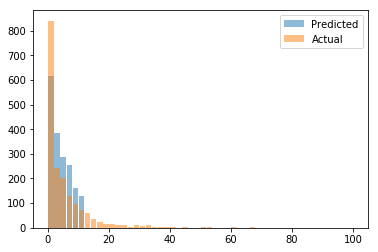

In [247]:
plt.hist(wtmodel.predict(data), alpha=0.5, bins = 50, rwidth=0.9, range = (0,100), label='Predicted')
plt.hist(ytrain[:,1], alpha=0.5, bins = 50, rwidth=0.9, range = (0,100),  label='Actual')
plt.legend(loc='upper right')